In [57]:
import numpy as np
import math


# Methods will __(  )__ are magic methods in python and the ones without are specially designed by us 
class Value:
    def __init__(self , data , _children =() , _operation = '' , label =''):
        self.data = data
        self._prev = set(_children)
        self._operation = _operation
        self.label = label
        self.grad = 0.0 # Initially 0
        self._backward = lambda: None 
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__ (self, other):
        
        other = other if isinstance(other , Value) else Value(other) # To enable addition of constants to Value obj
        out = Value(self.data + other.data , (self, other) , '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward 
            
        return out
    
    def __mul__(self, other):
        
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data * other.data , (self, other) ,'*') 
        
        def _backward() : 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # Allows other*self ; when that is not found it searches for rmul 
        return self*other
    
    def tanh(self):
        t = np.tanh(self.data)
        out = Value (t, (self,) , 'tanh')
        
        def _backward() : 
            self.grad += (1- t**2)*out.grad
        
        out._backward = _backward
        
        return out 
    
    def sigmoid(self):
        t = 1/(1+ math.exp(-self.data))
        out = Value (t, (self,), 'sig(x)')
        
        def _backward():
            self.grad += (t * (1 - t)) * out.grad
            
        out._backward = _backward
        
        return out 
    
    def relu(self):
        t = max(0, self.data)
        out = Value(t, (self,), 'relu(x)')

        def _backward():
            self.grad += (self.data > 0) * out.grad

        out._backward = _backward

        return out
    
    def softmax(self):
        exp_values = [math.exp(xi) for xi in self.data]
        sum_exp_values = sum(exp_values)
        softmax_values = [xi / sum_exp_values for xi in exp_values]

        out = Value(softmax_values, (self,), 'softmax(x)')

        def _backward():
            for i in range(len(self.data)):
                self.grad[i] += (softmax_values[i] * (1 - softmax_values[i])) * out.grad[i]

        out._backward = _backward

        return out
    
    def exp(self):
        t = math.exp(self.data)
        out = Value (t, (self,), 'e^x')
        
        def _backward():
            self.grad += t * out.grad
            
        out._backward = _backward
        
        return out 
    
    def __truediv__(self, other):
        out = self * (other**-1)
        return out 

    def __neg__(self):
        out = -1 * self.data
        return out 
    
    def __sub__(self , other):
        out = self + (-other)
        return out 
        
    def __pow__(self, other): # Only allowing constant power ; this way gradient will be fixed and simple.
        assert isinstance(other , (float,int)) 
        t = self.data**other
        out = Value (t, (self,) , f'^{other}')
        
        def _backward():
            self.grad = other * (self.data**(other-1)) * out.grad
            
        out._backward = _backward
        
        return out
        
        
    def backward(self):
        # Defining a function topo which stores all the nodes in a left to right manner in descending order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
# _children and _operation instroduced here to maintain expression graphs
# +- is to account for multiple contributions and no overwriting of grads

In [43]:
# We want to visualise the expressions
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad%.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._operation:
            # if this value is a result of some operation, create an operation node for it
            dot.node(name =  uid + n._operation, label = n._operation)
            # and connect this node to it
            dot.edge(uid + n._operation , uid)

    for n1, n2 in edges:
        # connect n1 to the operation node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot

# Why can't we change the name ? It doesn't work if we do!

In [44]:
a = Value(2.0 , label = 'a')
b = Value(-3.0, label = 'b')
c = Value(8.0,  label = 'c')
e = a*b ; e.label= 'e'
d = e + c ; d.label ='d'
f = Value(-2.0 , label = 'f')

L = f*d ; L.label = 'L'

In [45]:
# Doing backprop manually :
L.grad = 1
d.grad = L.grad * f.data
f.grad = L.grad * d.data
e.grad = d.grad
c.grad = d.grad 
b.grad = a.data * e.grad 
a.grad = b.data * e.grad

# Things to observe are that for the addition operation the same grad is propoated to the nodes ; for the binary
# multiplaction, the data of the other is multiplied to the grad of the forward step.

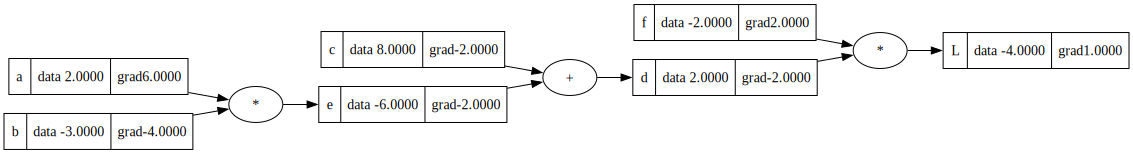

In [46]:
draw_dot(L) # Shows Forward and Bakward Propogation

In [47]:
# Creating simple dense neuron with tanh activation manually

In [55]:
w1 = Value(1.0 , label = 'w1')
w2 = Value(2.0 , label = 'w2')
x1 = Value(0.0 , label = 'x1')
x2 = Value(3.0 , label = 'x2')

w1x1 = w1*x1 ; w1x1.label= 'w1x1'
w2x2 = w2*x2 ; w2x2.label= 'w2x2'

w1x1w2x2 = w1x1+w2x2 ; w1x1w2x2.label= 'w1x1+w2x2'

b = Value(-5.4 , label = 'b')

n = w1x1w2x2 + b ; n.label = 'n'

e = (2*n).exp() ;  e.label = 'e'

o =  (e - 1 ) / (e + 1) ; o.label = 'o'

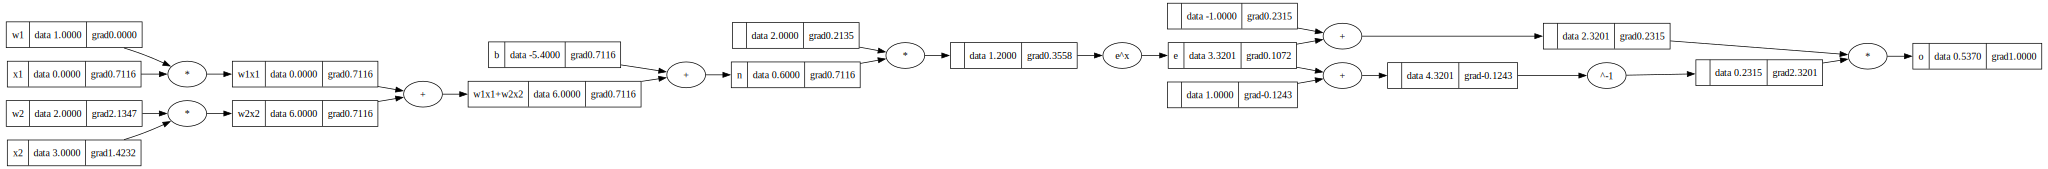

In [56]:
o.backward()

draw_dot(o)

# This shows a simple forward pass and a backward pass.